In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [474]:
def angle_cos(p0, p1, p2):
    d1, d2 = (p0-p1).astype('float'), (p2-p1).astype('float')
    return abs(np.dot(d1, d2) / np.sqrt( np.dot(d1, d1)*np.dot(d2, d2)))

def IOU(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    # Calculate the coordinates of the two rectangles
    x1_min, x1_max = x1 - w1/2, x1 + w1/2
    y1_min, y1_max = y1 - h1/2, y1 + h1/2
    x2_min, x2_max = x2 - w2/2, x2 + w2/2
    y2_min, y2_max = y2 - h2/2, y2 + h2/2

    # Calculate the intersection area
    x_overlap = max(0, min(x1_max, x2_max) - max(x1_min, x2_min))
    y_overlap = max(0, min(y1_max, y2_max) - max(y1_min, y2_min))
    intersection = x_overlap * y_overlap

    # Calculate the union area
    union = w1 * h1 + w2 * h2 - intersection

    # Calculate the IoU
    iou = intersection / union

    return iou

def find_squares(img):
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img = cv2.GaussianBlur(img, (5, 5), 0)
    squares = []
    coors = []
    for gray in cv2.split(img):
        for thrs in range(0, 255, 50):
            if thrs == 0:
                bin = cv2.Canny(gray, 0, 50, apertureSize=5)
                bin = cv2.dilate(bin, (3,3), iterations=1)
            else:
                retval, bin = cv2.threshold(gray, thrs, 255, cv2.THRESH_BINARY)
            contours, hierarchy = cv2.findContours(bin, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
            for cnt in contours:
                cnt_len = cv2.arcLength(cnt, True)
                cnt = cv2.approxPolyDP(cnt, 0.02*cnt_len, True)
                if len(cnt) == 4 and cv2.contourArea(cnt) > 1000 and cv2.contourArea(cnt) < 15000 and cv2.isContourConvex(cnt):
                    cnt = cnt.reshape(-1, 2)
                    max_cos = np.max([angle_cos( cnt[i], cnt[(i+1) % 4], cnt[(i+2) % 4] ) for i in range(4)])
                    if max_cos < 0.1:
                        squares.append(cnt)
                        coors.append(cv2.boundingRect(cnt))
                        
    return squares, coors

In [596]:
image = cv2.imread('data/1.png')
rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cnt, coor = find_squares(image)

In [597]:
# Apply NMS
bbox_list_thresholded = coor.copy()
bbox_list_new = []

while len(bbox_list_thresholded) > 0:
    current_box = bbox_list_thresholded.pop(0)
    bbox_list_new.append(current_box)
    for box in bbox_list_thresholded:
        iou = IOU(current_box, box)
        if iou > 0.9:
            bbox_list_thresholded.remove(box)
            
bbox_list_new

[(248, 405, 96, 106),
 (43, 199, 127, 126),
 (117, 358, 133, 133),
 (262, 259, 136, 132),
 (409, 177, 134, 132),
 (294, 147, 134, 131),
 (187, 119, 130, 126)]

In [598]:
index = []
for i in range(len(coor)):
    for j in range(len(bbox_list_new)):
        if coor[i] == bbox_list_new[j]:
            index.append(i)
            
index = index[:len(bbox_list_new)]
c = [cnt[i] for i in index]

In [599]:
# Count areas
areas = []
for a in c:
    area_in_pxl = cv2.contourArea(a)
    # say 1cm = 47 pxl
    area_in_cm = area_in_pxl/47
    
    # 1cm = 50m (base on google map)
    real_area = area_in_cm*50
    areas.append(round(real_area,2))

Jumlah kolam: 7


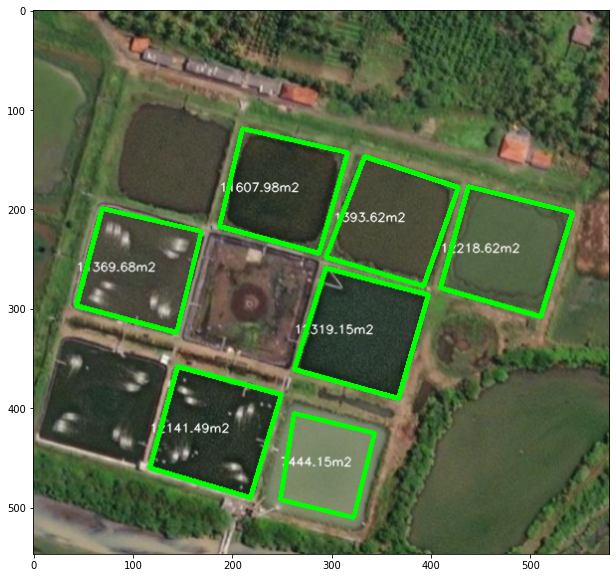

In [600]:
# Draw result
for i in range(len(bbox_list_new)):
    x,y,w,h = bbox_list_new[i]
    area = areas[i]
    cv2.putText(rgb, str(area)+'m2', (x,y+h//2), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, cv2.LINE_AA)

cv2.drawContours(rgb, c, -1, (0, 255, 0), 3)
plt.figure(figsize =(20,10))
plt.imshow(rgb)
print('Jumlah kolam: ' + str(len(c)))